# TS7: Filtrado digital lineal de ECG
Actualizacion: 20-06

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()
from pytc2.sistemas_lineales import plot_plantilla
from scipy import signal as sig
import scipy.io as sio

## Carga ECG

In [2]:
from utils_info import print_info_senal
fs = 1000  # Hz
mat_struct = sio.loadmat('ECG_TP4.mat')
ecg_lead = mat_struct['ecg_lead'].flatten()
ecg_lead = (ecg_lead - ecg_lead.mean())/ ecg_lead.std() 
N = ecg_lead.shape[0]
print_info_senal('ECG', ecg_lead, fs)

------ECG------
Cantidad de muestras:  1129116
Frecuencia de muestreo: 1000 Hz
Duracion de la señal: 1129.116 seg
Df: 0.001 Hz
Potencia:  1.0



## Armado de la Plantilla Band Pass Filter

### Definición de la plantilla de filtrado

Para definir la plantilla de filtrado de la señal ECG, usé los siguientes parámetros:

- **Banda de paso**: [1.0, 35.0] Hz  
- **Bandas de stop**: [0 - 0.1]HZ y [35 - 50]Hz
- **Ripple en la banda de paso**: 1 dB  
- **Atenuación en la banda de stop**: 40 dB  

La elección de la banda de paso está basada en el análisis espectral que hicimos en la TS5. Ahí vimos que la mayor parte de la energía útil de la señal ECG se concentra entre 1 y 35 Hz (en mi caso se concentraba hasta 25 Hz, pero en clase acordamos que se podía tomar hasta 35 Hz como referencia general).

Agregué una banda de stop desde 0 Hz hasta 0.1 Hz para eliminar componentes de muy baja frecuencia, como el movimiento de la línea de base.

Por otro lado, incluí una banda de stop que inicia en 50 Hz para suprimir el típico **ruido de línea**. La atenuación que puse (40 dB) es una exigencia razonable: logra una buena supresión sin hacer que el filtro sea innecesariamente complejo. El ripple de 1 dB en la banda de paso es tolerable.



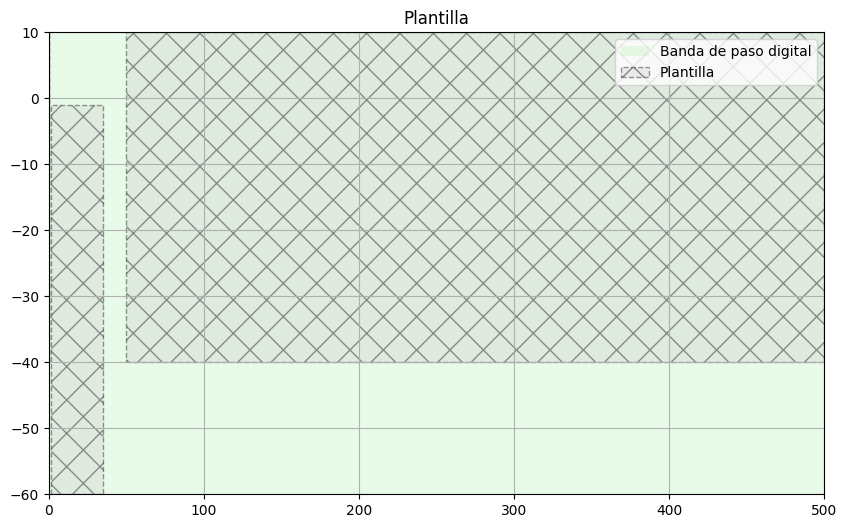

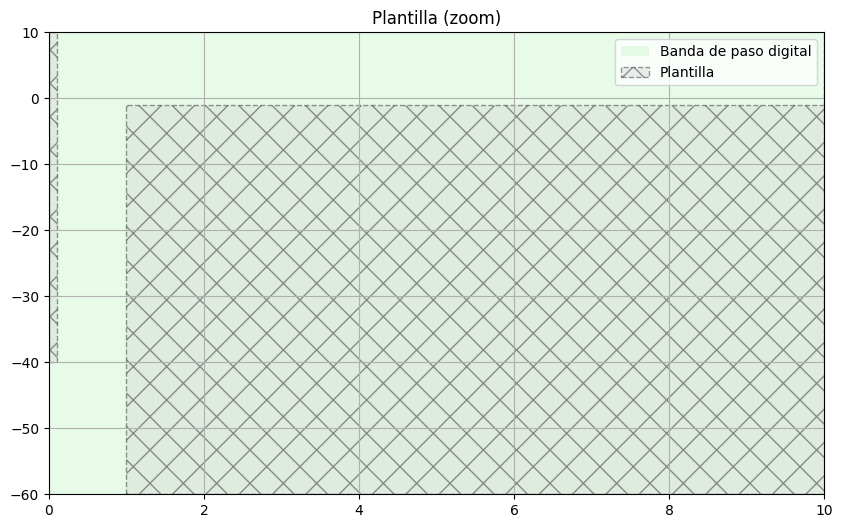

In [3]:
fpass = np.array([1.0, 35.0])       
fstop = np.array([0.1, 50.0])       
ripple = 1                         
attenuation = 40  

fig = plt.figure(figsize=(10, 6))
plt.title('Plantilla')
plt.grid(which='both', axis='both')
plt.xlim([0, 500])
plt.ylim([-60, 10]) 
plot_plantilla(filter_type='bandpass',fpass=fpass,ripple=ripple,fstop=fstop,attenuation=attenuation,fs=fs)
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 6))
plt.title('Plantilla (zoom)')
plt.grid(which='both', axis='both')
plt.xlim([0, 10])
plt.ylim([-60, 10]) 
plot_plantilla(filter_type='bandpass',fpass=fpass,ripple=ripple,fstop=fstop,attenuation=attenuation,fs=fs)
plt.legend()
plt.show()


### Grilla de frecuencias con más resolución

Armé una grilla de frecuencias `w_Hz` con más puntos en las bandas de transición, sobre todo en la primera, que es bastante exigente. Para eso usé `logspace` en la parte baja del espectro y después `linspace` desde 57 Hz hasta Nyquist, así tengo buena resolución donde el filtro cambia fuerte. 

Después convertí todo a radianes y de nuevo a Hz para tener la grilla final. Esto me permite ver bien cómo se comporta el filtro justo en las zonas críticas.


In [4]:
w_Hz_raw = np.append(np.logspace(-2, 0.8, 250), np.logspace(0.9, 1.75, 250))
w_Hz_raw = np.append(w_Hz_raw, np.linspace(57, fs/2, 500))
w_rad = w_Hz_raw / (fs/2) * np.pi
w_Hz = w_rad / np.pi * (fs/2)

## FIR

- **Método de Ventanas**: Kaiser  
- **Least Squares**  
- **Remez**

La idea es armar por separado un **Low Pass** y un **High Pass**, y después convolucionarlos para obtener el pasa banda final. Esto lo hago porque la plantilla que estoy usando es bastante exigente y no tiene simetría, así que si diseño un pasa banda directamente, no va a funcionar bien.


### Comentarios sobre los métodos:

- **Ventanas (Kaiser)**: se usa Kaiser porque es parametrizable, lo que permite ajustar la atenuación y el ancho de la transición. Es simple y directo.

- **Least Squares**: este método siempre converge, más allá de que la plantilla sea muy exigente. Busca minimizar el error cuadrático entre la respuesta ideal y la del filtro.

- **Remez (Parks-McClellan)**: cuando logra converger, suele dar un filtro muy ajustado a la plantilla. Pero si el diseño es muy exigente o poco simétrico, puede no encontrar solución. (charlado en clase)


#### HIGH PASS

### Diseño del filtro pasa altos (High Pass)

Aunque la plantilla general pide un ripple de 1 dB en la banda de paso, para el diseño del filtro pasa altos decidí ser más exigente y usar un **ripple de 0.1 dB**. Esto es porque la primera banda de transición (de 0.1 Hz a 1 Hz) es muy angosta, así que se necesita más precisión para que el filtro la respete bien.

#### Ventanas (Kaiser)

En este caso usé `firwin2` con una ventana de Kaiser. Además de bajar el ripple, **corrí un poco la banda de stop** (de 0.1 a 0.25 Hz) para facilitar la convergencia. Esto me permite suavizar un poco la exigencia en esa zona, sin comprometer demasiado la respuesta del filtro. Puse un valor alto para la atenuación (50 dB) para que el stopband quede bien marcado.

Para que este método funcionara con esta plantilla tan exigente, **tuve que usar muchísimos coeficientes** (12005). Con menos, el filtro no cumplía bien la especificación.

#### Least Squares

Con `firls` mantuve las frecuencias originales de la plantilla (0.1 Hz y 1 Hz) y también el ripple bajo. Este método es más tolerante con las transiciones difíciles, así que no hizo falta modificar nada. La ventaja de Least Squares es que **siempre converge**, incluso con plantillas complicadas como esta.

Igual que con ventanas, **necesité usar una cantidad altísima de coeficientes** (9005) para que se ajustara correctamente.

#### Remez (Parks-McClellan)

Para `remez`, definí la banda de stop entre 0 y 0.1 Hz, y la de paso a partir de 1 Hz. El deseado fue `[0, 1]` (ganancia cero en la primera banda, uno en la segunda). Este método es bastante sensible a las transiciones cortas.

Acá **usé el máximo número de coeficientes que me dejaba sin tirar error** (2501). Si ponía más, directamente no convergía. Aun así, el resultado fue bastante bueno para ese límite.


In [5]:
ripple_2 = 0.1
frecs_hp = np.array([0.0, fstop[0], fpass[0], fs/2]) # 0 Hz, 0.1 Hz, 1 Hz, fs/2
frecs_hp_kaiser = np.array([0.0, 0.25, fpass[0], fs/2]) # 0 Hz, 0.1 Hz, 1 Hz, fs/2
gains_db_hp = np.array([-attenuation, -attenuation, -ripple_2, -ripple_2])
gains_db_hp_kaiser = np.array([-50, -40, -ripple_2, -ripple_2])
gains_hp = 10**(gains_db_hp / 20)
gains_hp_kaiser = 10**(gains_db_hp_kaiser / 20)


''' FIR: VENTANA - Kaiser '''
coef_k = 12005
num_k_hp = sig.firwin2(coef_k, frecs_hp_kaiser, gains_hp_kaiser, window=('kaiser',14), fs=fs)
_, h_k_hp = sig.freqz(num_k_hp, worN=w_rad)

''' FIR: Least Squares '''
coef_ls = 9005 
num_firls_hp = sig.firls(coef_ls, frecs_hp, gains_hp, fs=fs)
_, h_firls_hp = sig.freqz(num_firls_hp, worN=w_rad)

''' FIR: Remez '''
coef_r_hp = 2501
bands_hp = [0.0, fstop[0], fpass[0], fs/2]  # Stop: 0–0.1 Hz, Pass: 1–500 Hz
desired_hp = [0, 1]                         # Ganancia por banda
num_remez_hp = sig.remez(coef_r_hp, bands_hp, desired_hp, fs=fs)
_, h_remez_hp = sig.freqz(num_remez_hp, worN=w_rad)

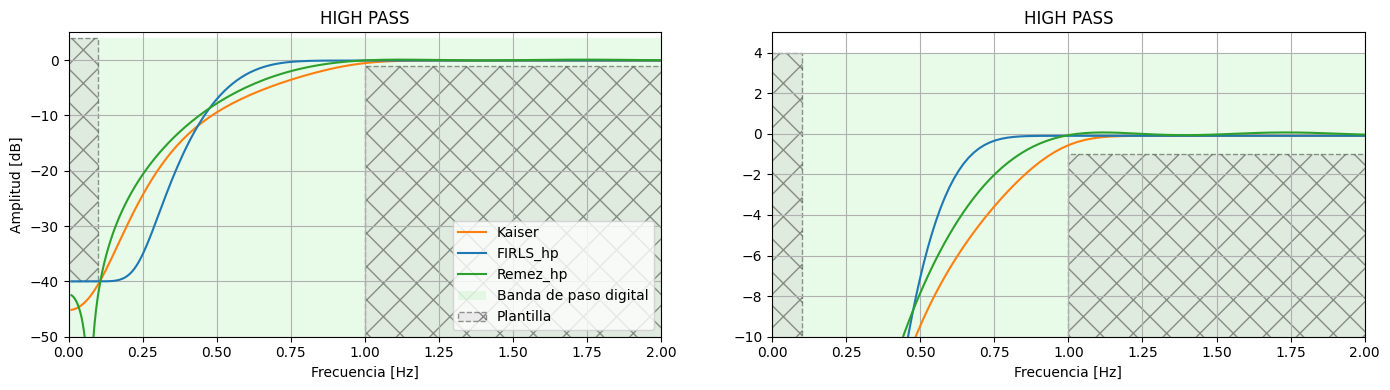

In [6]:
fig = plt.figure(figsize=(14, 4))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 0.005, 1])  # 2:gap:1 = 66%-gap-34%

ax1 = fig.add_subplot(gs[0, 0])
plt.sca(ax1)
plt.plot(w_Hz, 20 * np.log10(np.abs(h_k_hp) + 1e-10), color='tab:orange', label='Kaiser')
plt.plot(w_Hz, 20 * np.log10(np.abs(h_firls_hp) + 1e-10), label='FIRLS_hp', color='tab:blue')
plt.plot(w_Hz, 20 * np.log10(np.abs(h_remez_hp) + 1e-10), label='Remez_hp', color='tab:green')
plot_plantilla(filter_type='highpass',fpass=1.0,ripple=1.0,fstop=0.1,attenuation=40.0,fs=fs)
plt.title('HIGH PASS')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.ylim(-50, 5)
plt.xlim(0, 2)
plt.grid(True)
plt.legend(loc='lower right')

ax2 = fig.add_subplot(gs[0, 2])
plt.sca(ax2)
plt.plot(w_Hz, 20 * np.log10(np.abs(h_k_hp) + 1e-10), color='tab:orange', label='Kaiser')
plt.plot(w_Hz, 20 * np.log10(np.abs(h_firls_hp) + 1e-10), color='tab:blue', label='FIRLS_hp')	
plt.plot(w_Hz, 20 * np.log10(np.abs(h_remez_hp) + 1e-10), color='tab:green', label='Remez_hp')
plot_plantilla(filter_type='highpass',fpass=1.0,ripple=1.0,fstop=0.1,attenuation=40.0,fs=fs)
plt.title('HIGH PASS')
plt.xlabel('Frecuencia [Hz]')
plt.xlim(0, 2)
plt.ylim(-10, 5)
plt.grid(True)
plt.tight_layout()
plt.show()

Los 3 filtros cumplen la plantilla

- **FIRLS** es el que **sube primero** en la banda de transición.

- **Kaiser** es el que **más tarda en subir**.

- **Remez** tiene un comportamiento raro en la zona de 0 a 0.1 Hz.


### Diseño del filtro pasa bajos (Low Pass)

Para el diseño del low pass usé una plantilla con ripple de **0.5 dB** en la banda de paso y **atenuación de 40 dB** en la banda de stop. Las transiciones no son tan exigentes como en el high pass, así que no fue necesario usar tantos coeficientes.

En el caso de **Kaiser**, ajusté un poco la banda de stop: en lugar de cortar exactamente en 50 Hz, lo bajé a 49 Hz. Esto lo hice para evitar problemas de convergencia y darle un poco más de margen.

- Con **Kaiser** usé **7005 coeficientes**.
- Con **Least Squares**, solamente **305 coeficientes**.
- Y con **Remez**, **201 coeficientes**. 

Se nota que como la plantilla es menos exigente, no hace falta forzar tanto los métodos como en el caso anterior.


In [7]:
ripple_2 = 0.5
ripple_1 = 1.0
frecs_lp = np.array([0.0, fpass[1], fstop[1], fs/2]) 
frecs_lp_kaiser = np.array([0.0, fpass[1], 49, fs/2]) 
gains_db_lp = np.array([-ripple_2, -ripple_2, -attenuation, -attenuation])
gains_lp = 10**(gains_db_lp / 20)


''' FIR: VENTANA - Kaiser '''
coef= 7005
num_k_lp = sig.firwin2(coef, frecs_lp_kaiser, gains_lp, window=('kaiser',14), fs=fs)
_, h_k_lp = sig.freqz(num_k_lp, worN=w_rad)

''' FIR: Least Squares '''
coef_2 = 305
num_firls_lp = sig.firls(coef_2, frecs_lp, gains_lp, fs=fs)
_, h_firls_lp = sig.freqz(num_firls_lp, worN=w_rad)

''' FIR: Remez '''
coef_r_lp = 201
bands_lp = [0.0, fpass[1], fstop[1], fs/2]  
desired_lp = [1, 0]                         
num_remez_lp = sig.remez(coef_r_lp, bands_lp, desired_lp, fs=fs)
_, h_remez_lp = sig.freqz(num_remez_lp, worN=w_rad)



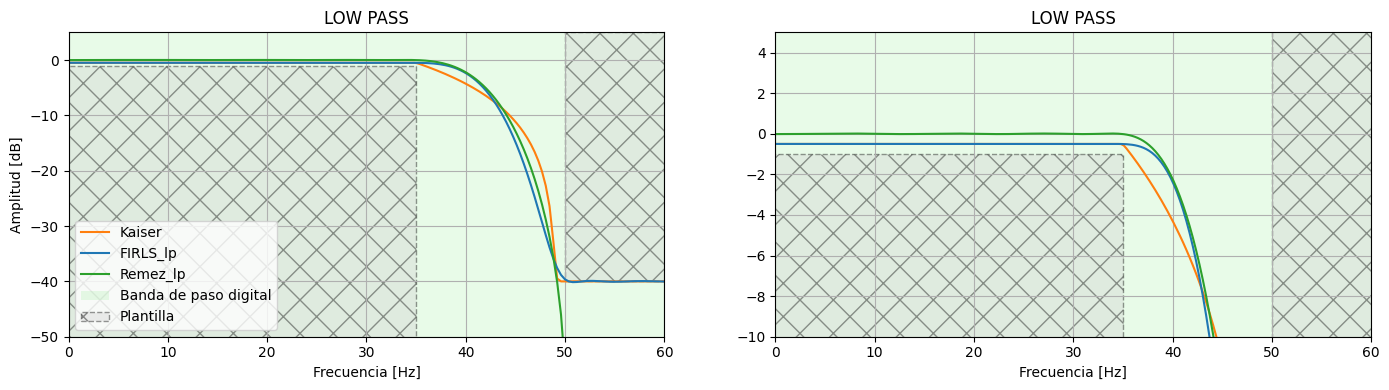

In [8]:
fig = plt.figure(figsize=(14, 4))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 0.005, 1])  # 2:gap:1 = 66%-gap-34%

ax1 = fig.add_subplot(gs[0, 0])
plt.sca(ax1)
plt.plot(w_Hz, 20 * np.log10(np.abs(h_k_lp) + 1e-10), color='tab:orange', label='Kaiser')
plt.plot(w_Hz, 20 * np.log10(np.abs(h_firls_lp) + 1e-10), label='FIRLS_lp', color='tab:blue')
plt.plot(w_Hz, 20 * np.log10(np.abs(h_remez_lp) + 1e-10), label='Remez_lp', color='tab:green')
plot_plantilla(filter_type='lowpass',fpass=35.0,ripple=1.0,fstop=50.0,attenuation=40.0,fs=fs)
plt.title('LOW PASS')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.ylim(-50, 5)
plt.xlim(0, 60)
plt.grid(True)
plt.legend(loc='lower left')

ax2 = fig.add_subplot(gs[0, 2])
plt.sca(ax2)
plt.plot(w_Hz, 20 * np.log10(np.abs(h_k_lp) + 1e-10), color='tab:orange', label='Kaiser')
plt.plot(w_Hz, 20 * np.log10(np.abs(h_firls_lp) + 1e-10), color='tab:blue', label='FIRLS_lp')	
plt.plot(w_Hz, 20 * np.log10(np.abs(h_remez_lp) + 1e-10), color='tab:green', label='Remez_lp')
plot_plantilla(filter_type='lowpass',fpass=35.0,ripple=1.0,fstop=50.0,attenuation=40.0,fs=fs)
plt.title('LOW PASS')
plt.xlabel('Frecuencia [Hz]')
plt.xlim(0, 60)
plt.ylim(-10, 5)
plt.grid(True)
plt.tight_layout()
plt.show()


Los 3 filtros cumplen la plantilla

### Construcción del filtro pasa banda (Band Pass)

Una vez que tuve los filtros pasa altos y pasa bajos, los combiné mediante **convolución** para obtener el filtro final pasa banda.

- `h_k_bp` es la convolución del low pass y high pass hechos con **Kaiser**
- `h_firls_bp` es la convolución con los filtros de **Least Squares**
- `h_remez_bp` es la convolución con los de **Remez**

Después calculé la respuesta en frecuencia de cada uno (`H_k_bp`, `H_firls_bp`, `H_remez_bp`) usando `freqz` sobre la misma grilla `w_rad`.


In [9]:
h_k_bp = np.convolve(num_k_lp, num_k_hp)
h_firls_bp = np.convolve(num_firls_lp, num_firls_hp)
h_remez_bp = np.convolve(num_remez_lp, num_remez_hp)
_, H_k_bp = sig.freqz(h_k_bp, worN=w_rad)
_, H_firls_bp = sig.freqz(h_firls_bp, worN=w_rad)
_, H_remez_bp = sig.freqz(h_remez_bp, worN=w_rad)

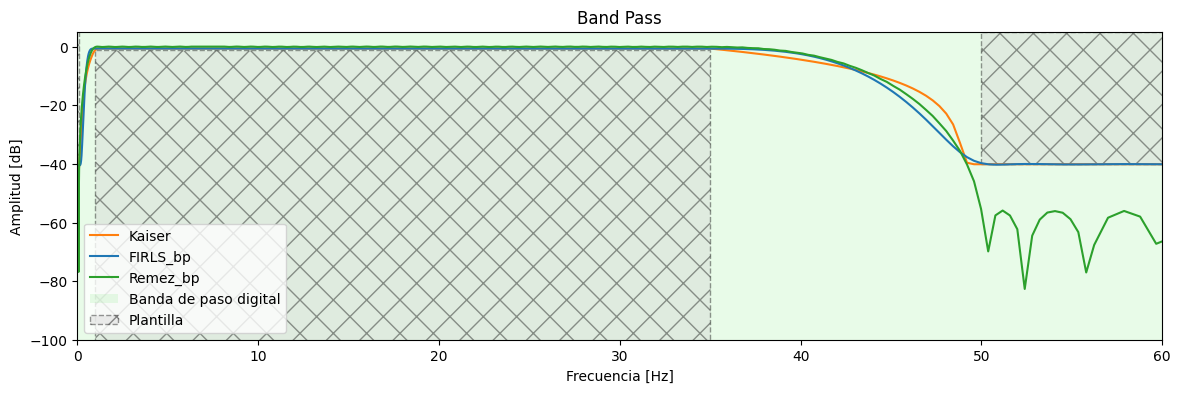

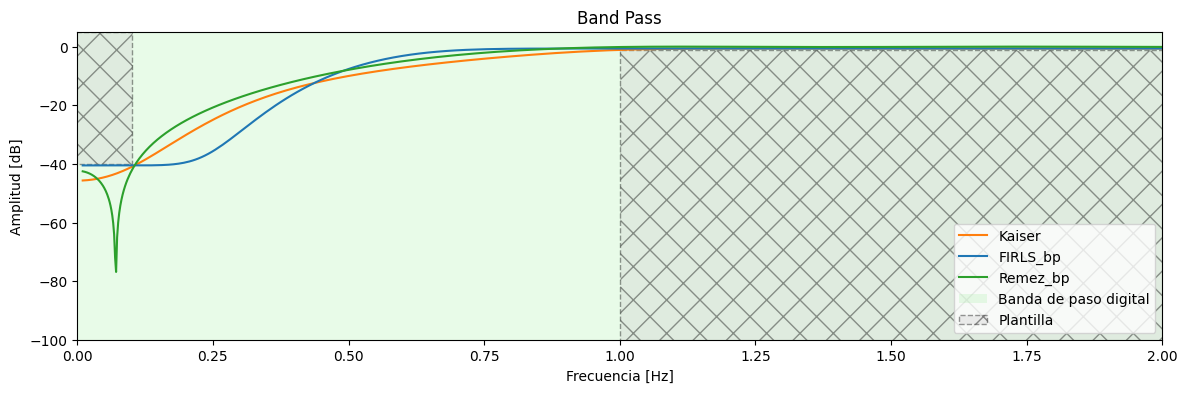

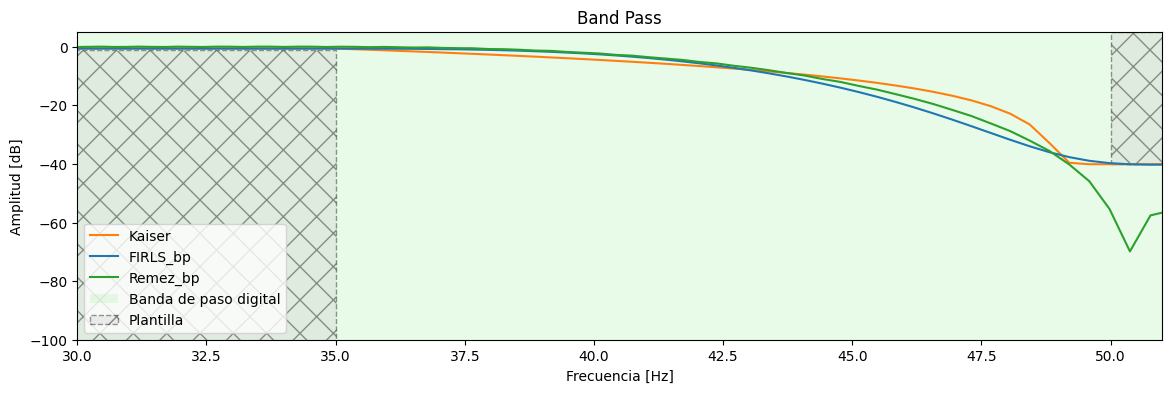

In [10]:
fig = plt.figure(figsize=(14, 4))
plt.plot(w_Hz, 20 * np.log10(np.abs(H_k_bp) + 1e-10), color='tab:orange', label='Kaiser')
plt.plot(w_Hz, 20 * np.log10(np.abs(H_firls_bp) + 1e-10), label='FIRLS_bp', color='tab:blue')
plt.plot(w_Hz, 20 * np.log10(np.abs(H_remez_bp) + 1e-10), label='Remez_bp', color='tab:green')
plot_plantilla(filter_type='bandpass',fpass=fpass,ripple=ripple,fstop=fstop,attenuation=attenuation,fs=fs)
plt.xlim(0, 60)
plt.title('Band Pass')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.legend()

fig = plt.figure(figsize=(14, 4))
plt.plot(w_Hz, 20 * np.log10(np.abs(H_k_bp) + 1e-10), color='tab:orange', label='Kaiser')
plt.plot(w_Hz, 20 * np.log10(np.abs(H_firls_bp) + 1e-10), label='FIRLS_bp', color='tab:blue')
plt.plot(w_Hz, 20 * np.log10(np.abs(H_remez_bp) + 1e-10), label='Remez_bp', color='tab:green')
plot_plantilla(filter_type='bandpass',fpass=fpass,ripple=ripple,fstop=fstop,attenuation=attenuation,fs=fs)
plt.xlim(0, 2)
plt.title('Band Pass')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.legend()

fig = plt.figure(figsize=(14, 4))
plt.plot(w_Hz, 20 * np.log10(np.abs(H_k_bp) + 1e-10), color='tab:orange', label='Kaiser')
plt.plot(w_Hz, 20 * np.log10(np.abs(H_firls_bp) + 1e-10), label='FIRLS_bp', color='tab:blue')
plt.plot(w_Hz, 20 * np.log10(np.abs(H_remez_bp) + 1e-10), label='Remez_bp', color='tab:green')
plot_plantilla(filter_type='bandpass',fpass=fpass,ripple=ripple,fstop=fstop,attenuation=attenuation,fs=fs)
plt.xlim(30, 51)
plt.title('Band Pass')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.legend()

### Comparación de los filtros Band Pass

En la figura se muestra la respuesta final de los tres filtros pasa banda obtenidos por convolución.

- **Los tres cumplen con la plantilla**, tanto en las bandas de paso como en las bandas de stop.
- El filtro de **Remez** sigue mostrando el **comportamiento raro en la zona baja**, igual que en el high pass: una bajada seguida de una subida antes de estabilizarse.

Fuera de eso, todos los diseños funcionan correctamente como pasa banda.


## IIR

- **Butterworth**
- **Chebyshev Tipo 1**

Para comparar con los FIR, también diseñé filtros IIR usando las funciones de `iirdesign`.

Usé los mismos parámetros de la plantilla:

- **Banda de paso**: [1.0, 35.0] Hz  
- **Banda de stop**: [0.1, 50.0] Hz  
- **Ripple en banda de paso**: 0.1 dB  
- **Atenuación en banda de stop**: 40 dB  

Ambos filtros se diseñaron usando `output='sos'` para evitar problemas numéricos, y se graficó la respuesta en frecuencia con `sosfreqz`.

- `mi_sos_butter` es el filtro **Butterworth**, que se caracteriza por tener una transición suave y sin ripple.
- `mi_sos_cheby` es el filtro **Chebyshev tipo 1**, que permite tener una transición más rápida a costa de ripple en la banda de paso.

Después se evaluaron sobre la misma grilla `w_rad` para poder comparar directamente con los FIR.


In [11]:
fs = 1000
fpass = np.array([1.0, 35.0])       
fstop = np.array([0.1, 50.0])       
ripple = 0.1                         
attenuation = 40                    
''' IIR: Butterworth '''
mi_sos_butter = sig.iirdesign(
    fpass,
    fstop,
    gpass=ripple,
    gstop=attenuation,
    ftype='butter',
    output='sos',
    fs=fs
)
w_butter, hh_butter = sig.sosfreqz(mi_sos_butter, worN=w_rad)
''' IIR: Chebyshev 1 '''
mi_sos_cheby = sig.iirdesign(
    fpass,
    fstop,
    gpass=ripple,
    gstop=attenuation,
    ftype='cheby1',
    output='sos',
    fs=fs
)
w_cheby, hh_cheby = sig.sosfreqz(mi_sos_cheby, worN=w_rad)

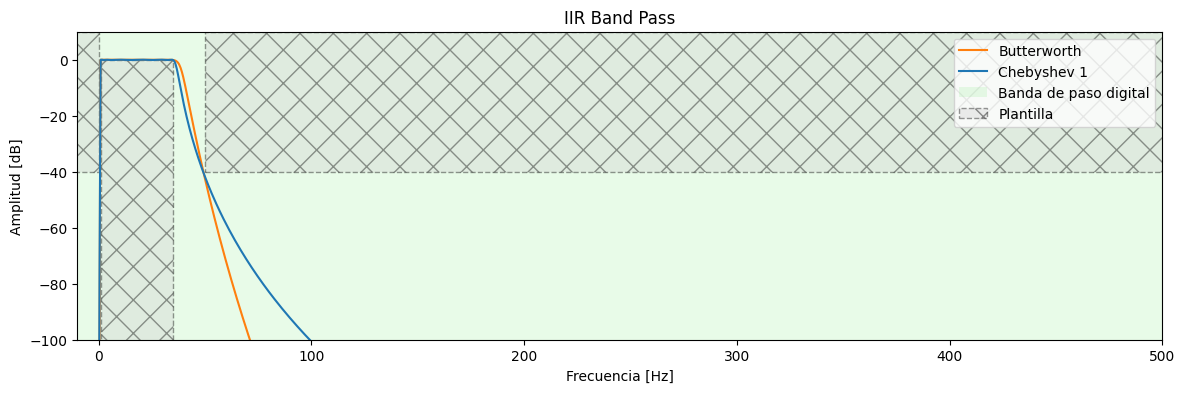

In [12]:
fig = plt.figure(figsize=(14, 4))
plt.plot(w_Hz, 20 * np.log10(np.abs(hh_butter) + 1e-10), color='tab:orange', label='Butterworth')
plt.plot(w_Hz, 20 * np.log10(np.abs(hh_cheby) + 1e-10), color='tab:blue', label='Chebyshev 1')
plot_plantilla(filter_type='bandpass', fpass=fpass, ripple=ripple, fstop=fstop, attenuation=attenuation, fs=fs)
plt.title('IIR Band Pass')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.xlim(-10, 500)
plt.legend()
plt.show()

### Aplicación de los filtros

#### IIR

Para aplicar los filtros IIR usé `sosfiltfilt`, que realiza un filtrado bidireccional. Esto es clave porque al hacer el filtrado hacia adelante y hacia atrás,  **se anula la fase** (efectivamente es como aplicar $ h(n) * h(-n)) $.

Esto evita la distorsión de fase, que es algo típico en los IIR.

#### FIR

En el caso de los FIR, directamente apliqué los filtros usando `np.convolve` con `mode='same'`. Como no hay parte recursiva, no necesito hacer nada más.

No usé `filtfilt` con los FIR porque no es necesario: si el filtro tiene **fase lineal**, el retardo es constante y no deforma la señal.


In [18]:
''' Aplicación de filtros IIR '''
ecg_lead_iir_butter = sig.sosfiltfilt(mi_sos_butter, ecg_lead)
ecg_lead_iir_cheby = sig.sosfiltfilt(mi_sos_cheby, ecg_lead)

''' Aplicación de filtros FIR '''
# Podria usar Lfilter o convolve
ecg_lead_fir_k = np.convolve(ecg_lead, h_k_bp, mode='same')
ecg_lead_fir_firls = np.convolve(ecg_lead, h_firls_bp, mode='same')
ecg_lead_fir_remez = np.convolve(ecg_lead, h_remez_bp, mode='same')



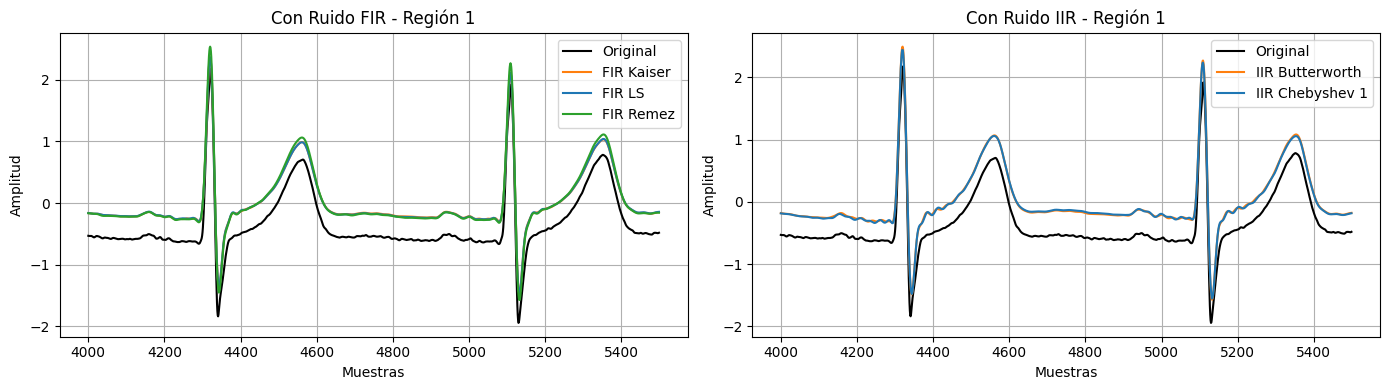

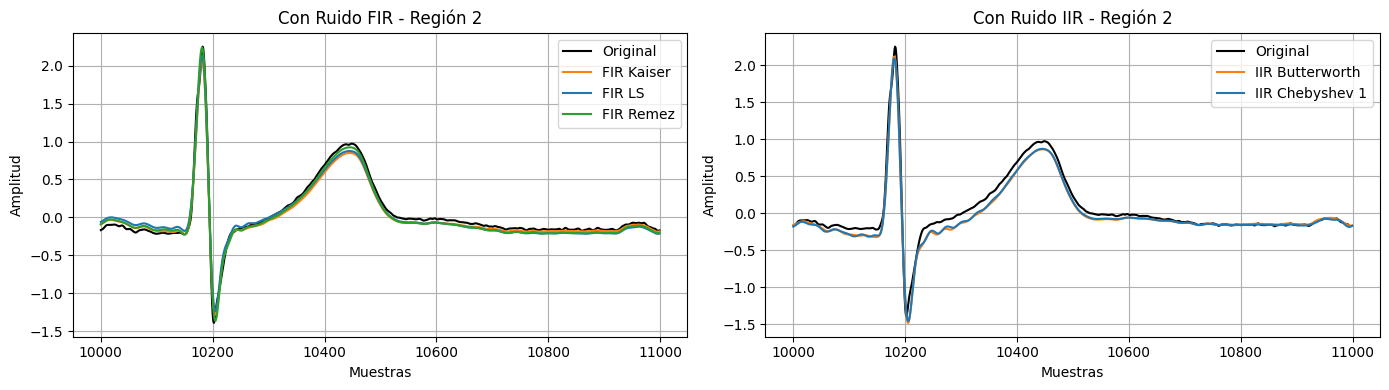

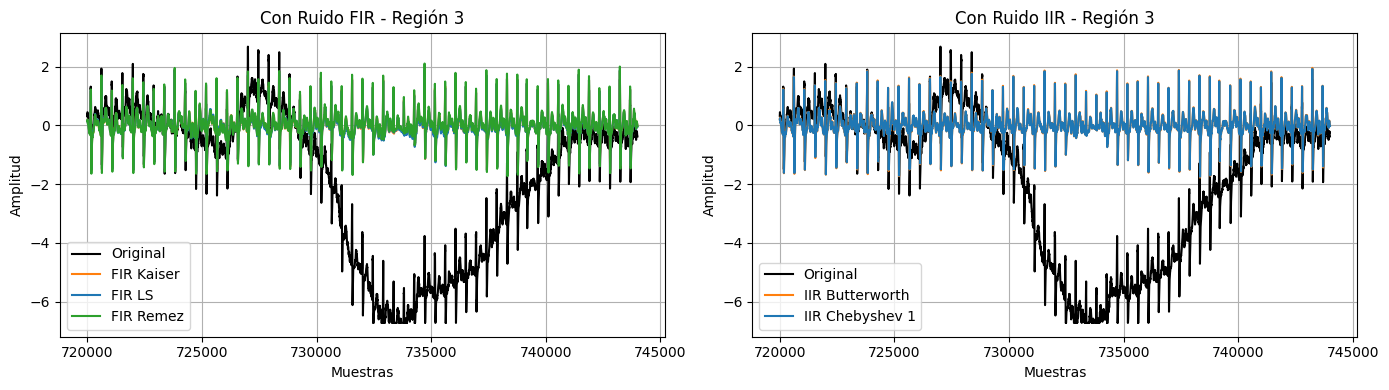

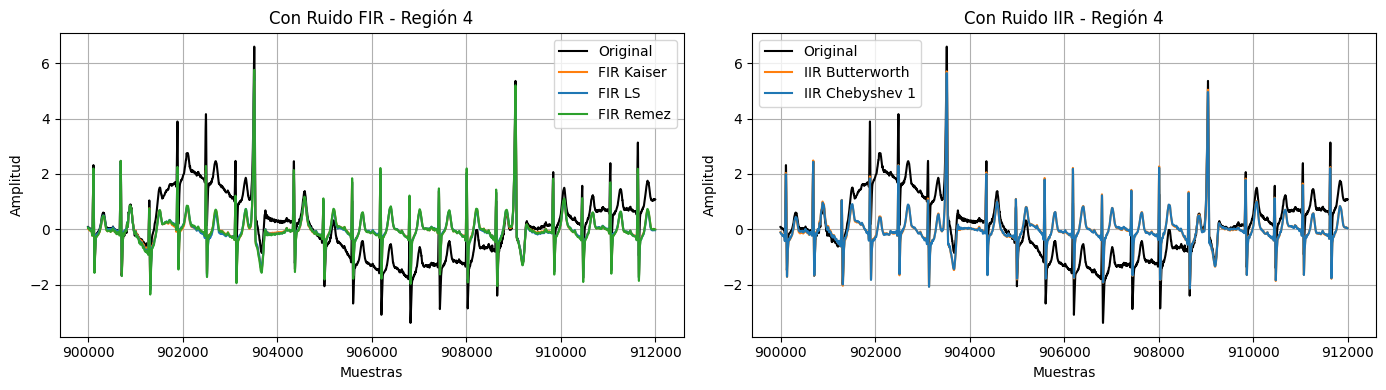

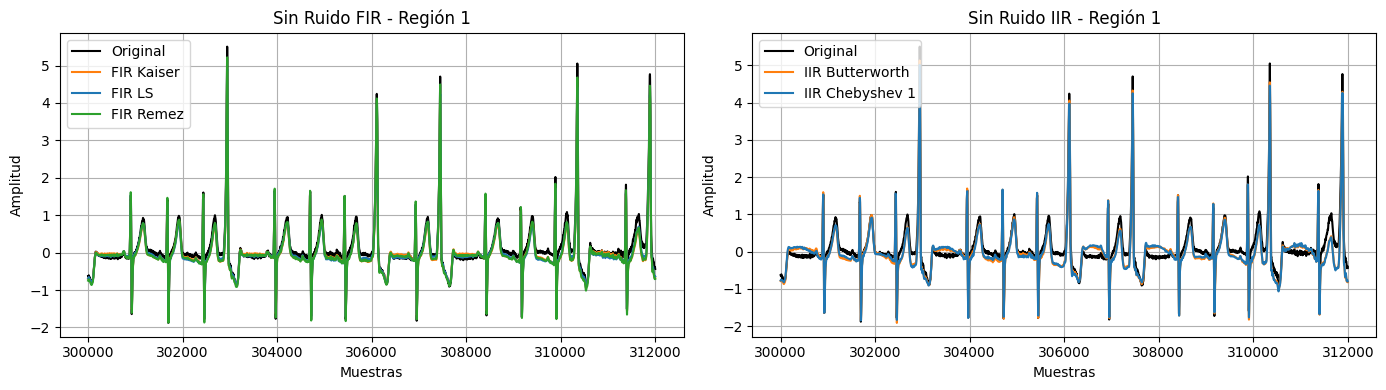

In [19]:
regs_con_ruido = [
    [4000, 5500],
    [10000, 11000],
    (np.array([12, 12.4]) * 60 * fs).astype(int),
    (np.array([15, 15.2]) * 60 * fs).astype(int)
]

regs_sin_ruido = [
    (np.array([5, 5.2]) * 60 * fs).astype(int),
]

# Función para plotear
def plot_comparacion_filtros(ecg_original, ecg_fir_k, ecg_fir_firls, ecg_fir_remez,
                              ecg_iir_butter, ecg_iir_cheby, regiones, titulo_base):
    for i, (start, end) in enumerate(regiones):
        eje_x = np.arange(start, end)
        fig, axs = plt.subplots(1, 2, figsize=(14, 4))
        
        # FIR
        axs[0].plot(eje_x, ecg_original[start:end], label='Original', color='k')
        axs[0].plot(eje_x, ecg_fir_k[start:end], label='FIR Kaiser', color='tab:orange')
        axs[0].plot(eje_x, ecg_fir_firls[start:end], label='FIR LS', color='tab:blue')
        axs[0].plot(eje_x, ecg_fir_remez[start:end], label='FIR Remez', color='tab:green')
        axs[0].set_title(f'{titulo_base} FIR - Región {i+1}')
        axs[0].set_xlabel('Muestras')
        axs[0].set_ylabel('Amplitud')
        axs[0].legend()
        axs[0].grid(True)

        # IIR
        axs[1].plot(eje_x, ecg_original[start:end], label='Original', color='k')
        axs[1].plot(eje_x, ecg_iir_butter[start:end], label='IIR Butterworth', color='tab:orange')
        axs[1].plot(eje_x, ecg_iir_cheby[start:end], label='IIR Chebyshev 1', color='tab:blue')
        axs[1].set_title(f'{titulo_base} IIR - Región {i+1}')
        axs[1].set_xlabel('Muestras')
        axs[1].set_ylabel('Amplitud')
        axs[1].legend()
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()



plot_comparacion_filtros(ecg_lead, ecg_lead_fir_k, ecg_lead_fir_firls, ecg_lead_fir_remez,
                         ecg_lead_iir_butter, ecg_lead_iir_cheby, regs_con_ruido, 'Con Ruido')

plot_comparacion_filtros(ecg_lead, ecg_lead_fir_k, ecg_lead_fir_firls, ecg_lead_fir_remez,
                         ecg_lead_iir_butter, ecg_lead_iir_cheby, regs_sin_ruido, 'Sin Ruido')


### Señales filtradas

Ambas técnicas, tanto **FIR** como **IIR**, lograron filtrar correctamente la señal ECG.

Se puede observar claramente cómo se corrige el **corrimiento de línea de base**, que era visible en la señal original. Después del filtrado, la morfología de los complejos QRS se conserva bien y la señal queda limpia.

## BONUS :)

Para el bonus repetí todo el procedimiento de diseño y aplicación de filtros, pero esta vez sobre la señal **PPG**.

- **Banda de paso**: 0.5 Hz a 5 Hz  
  Esta banda permite conservar las componentes fisiológicas relevantes de la señal PPG, principalmente asociadas a la actividad cardíaca y respiratoria.

- **Banda de stop**:
  - Inferior: 0 Hz a 0.2 Hz → elimina muy baja frecuencia (movimientos, artefactos lentos).
  - Superior: 8 Hz a fs/2 → atenúa componentes de alta frecuencia no deseadas.

Los parámetros de diseño fueron:

- **Ripple en banda de paso**: 1 dB  
- **Atenuación en banda de stop**: 40 dB

Se aplicaron los mismos métodos: FIR (con Kaiser, Least Squares y Remez), IIR (Butterworth y Chebyshev), y también se analizaron las señales filtradas para verificar la eliminación del ruido y el comportamiento de cada filtro.

In [20]:
from utils_info import print_info_senal
ppg_con_ruido = np.loadtxt('PPG.csv', delimiter=',')
ppg = ppg_con_ruido.flatten()
ppg = (ppg - ppg.mean()) / ppg.std()  # Normalizar la señal
N = ppg.shape[0]
fs = 400  
print_info_senal('PPG', ppg, fs)

------PPG------
Cantidad de muestras:  45320
Frecuencia de muestreo: 400 Hz
Duracion de la señal: 113.3 seg
Df: 0.009 Hz
Potencia:  1.0



## Plantilla

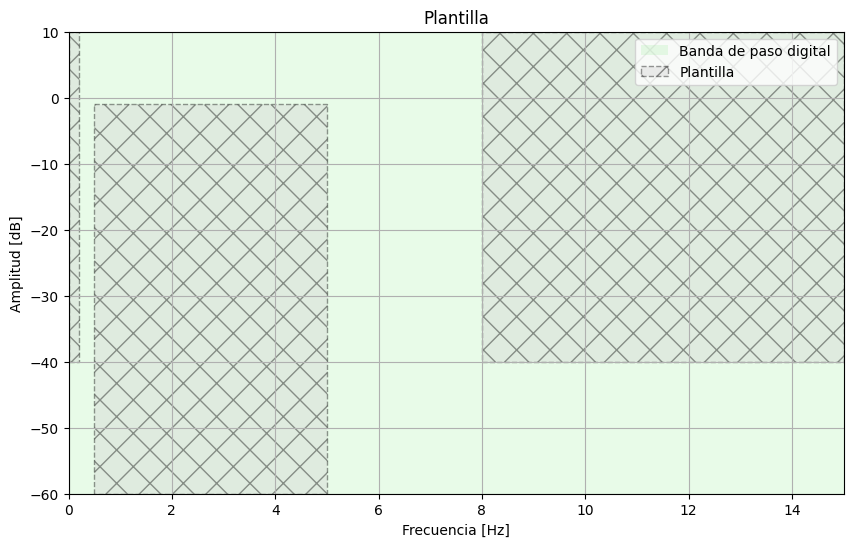

In [21]:
fpass = np.array([0.5, 5.0])      
fstop = np.array([0.2, 8.0])       
ripple = 1.0               
attenuation = 40            


fig = plt.figure(figsize=(10, 6))
plt.title('Plantilla')
plt.grid(which='both', axis='both')
plt.xlim([0, 15])
plt.ylim([-60, 10]) 
plot_plantilla(filter_type='bandpass',fpass=fpass,ripple=ripple,fstop=fstop,attenuation=attenuation,fs=fs)
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')

plt.legend()
plt.show()

### Grilla de frecuencias para PPG

Armé una grilla de frecuencias `w_Hz` con **mayor resolución en las bandas de transición**, que en este caso son bastante angostas (sobre todo la inferior, entre 0.2 y 0.5 Hz).

Usé:

- `logspace` para cubrir bien desde frecuencias muy bajas (0.01 Hz) hasta 0.9 Hz, con mayor densidad entre 0.01–0.5 y 0.6–0.9 Hz.
- `linspace` desde 9 Hz hasta Nyquist, para cubrir uniformemente las frecuencias altas.

Después convertí a radianes por segundo (`w_rad`) y luego de nuevo a Hz (`w_Hz`) para evaluar las respuestas de los filtros sobre esta grilla adaptada a la plantilla de PPG.


In [22]:
w_Hz_raw = np.append(np.logspace(-2, 0.5, 250), np.logspace(0.6, 0.9, 250))
w_Hz_raw = np.append(w_Hz_raw, np.linspace(9, fs/2, 500))

w_rad = w_Hz_raw / (fs/2) * np.pi
w_Hz = w_rad / np.pi * (fs/2)

# FIR

### Diseño de filtros FIR para PPG

Para la señal PPG armé el filtro **pasa banda** combinando un pasa altos y un pasa bajos, igual que en el caso de ECG.

---

#### High Pass

- Banda de stop: 0–0.2 Hz  
- Banda de paso: a partir de 0.5 Hz  
- Ripple: 0.1 dB  
- Atenuación: 40 dB

La plantilla es bastante exigente, así que en **Kaiser** le di un poco de margen corriendo la banda de stop hasta 0.35 Hz. También ajusté un poco las ganancias en dB para facilitar la convergencia, sobre todo en Remez. Tuve que usar **muchos coeficientes** (6005 para Kaiser, 3005 para FIRLS).

Remez funcionó bien con 1501 coeficientes, aunque sigue mostrando ese comportamiento raro en la zona baja (lo veremos en el gráfico).

---

#### Low Pass

- Banda de paso: hasta 5 Hz  
- Banda de stop: a partir de 8 Hz  
- Ripple: 0.5 dB  
- Atenuación: 40 dB

Acá el diseño fue más relajado. La transición no es tan agresiva, así que no hizo falta usar tantos coeficientes. Para Kaiser corrí el stop a 7 Hz para evitar que el filtro se vuelva demasiado exigente. Se usaron 7005 (Kaiser), 905 (FIRLS), y 601 (Remez).

---

#### Band Pass

La convolución de cada par de filtros (low y high) me dio el filtro final pasa banda para cada método:

- `h_k_bp`: Kaiser  
- `h_firls_bp`: Least Squares  
- `h_remez_bp`: Remez

Después calculé la respuesta en frecuencia de cada uno para compararlos visualmente.


In [23]:
#%%############################ 
#####  High pass filter   #####
###############################

ripple_2 = 0.1

# Plantilla ajustada para PPG
frecs_hp = np.array([0.0, fstop[0], fpass[0], fs/2])               # [0, 0.2, 0.5, 200]
frecs_hp_kaiser = np.array([0.0, 0.35, fpass[0], fs/2])             # más suave transición

# Ganancia en dB (plantilla)
gains_db_hp = np.array([-attenuation, -attenuation, -ripple_2, -ripple_2])
gains_db_hp_kaiser = np.array([-attenuation-20, -attenuation-30, -0.05, -ripple_2])
gains_db_hp_remez = np.array([-attenuation-20, -attenuation, -ripple_2, -ripple_2])

# Conversión a ganancia lineal
gains_hp = 10**(gains_db_hp / 20)
gains_hp_kaiser = 10**(gains_db_hp_kaiser / 20)
gains_hp_remez = 10**(gains_db_hp_remez / 20)

''' FIR: VENTANA - Kaiser '''
coef_k = 6005  # largo para buena selectividad
num_k_hp = sig.firwin2(coef_k, frecs_hp_kaiser, gains_hp_kaiser, window=('kaiser', 14), fs=fs)
_, h_k_hp = sig.freqz(num_k_hp, worN=w_rad)

''' FIR: Least Squares '''
coef_ls = 3005
num_firls_hp = sig.firls(coef_ls, frecs_hp, gains_hp, fs=fs)
_, h_firls_hp = sig.freqz(num_firls_hp, worN=w_rad)

''' FIR: Remez '''
coef_r_hp = 1501
bands_hp = [0.0, 0.2, fpass[0], fs/2]  # Stop: 0–0.2 Hz, Pass: 0.5–200 Hz
frecs_hp_re = np.array([0.0, 0.2, fpass[0], fs/2])   #le doy changui
desired_hp = [0, 1]
num_remez_hp = sig.remez(coef_r_hp, frecs_hp_re, gains_hp_remez[::2], fs=fs)
_, h_remez_hp = sig.freqz(num_remez_hp, worN=w_rad)

#%%############################ 
#####  Low  pass filter   #####
###############################
ripple_2 = 0.5
frecs_lp = np.array([0.0, fpass[1], fstop[1], fs/2])  # [0.0, 5.0, 8.0, 200.0]
frecs_lp_kaiser = np.array([0.0, fpass[1], 7, fs/2])  # para tener margen justo antes del stop
gains_db_lp = np.array([-ripple_2, -ripple_2, -attenuation, -attenuation])
gains_lp = 10**(gains_db_lp / 20)

# FIR: VENTANA - Kaiser
coef = 7005
num_k_lp = sig.firwin2(coef, frecs_lp_kaiser, gains_lp, window=('kaiser',14), fs=fs)
_, h_k_lp = sig.freqz(num_k_lp, worN=w_rad)

# FIR: Least Squares
coef_2 = 905
num_firls_lp = sig.firls(coef_2, frecs_lp, gains_lp, fs=fs)
_, h_firls_lp = sig.freqz(num_firls_lp, worN=w_rad)

# FIR: Remez
coef_r_lp = 601
bands_lp = [0.0, fpass[1], fstop[1], fs/2]  # [0.0, 5.0, 8.0, 200.0]
desired_lp = [1, 0]
num_remez_lp = sig.remez(coef_r_lp, bands_lp, desired_lp, fs=fs)
_, h_remez_lp = sig.freqz(num_remez_lp, worN=w_rad)

#%%############################ 
#####  Band pass filter   #####
###############################

h_k_bp = np.convolve(num_k_lp, num_k_hp, mode = 'same')
h_firls_bp = np.convolve(num_firls_lp, num_firls_hp, mode = 'same')
h_remez_bp = np.convolve(num_remez_lp, num_remez_hp, mode = 'same')
_, H_k_bp = sig.freqz(h_k_bp, worN=w_rad)
_, H_firls_bp = sig.freqz(h_firls_bp, worN=w_rad)
_, H_remez_bp = sig.freqz(h_remez_bp, worN=w_rad)


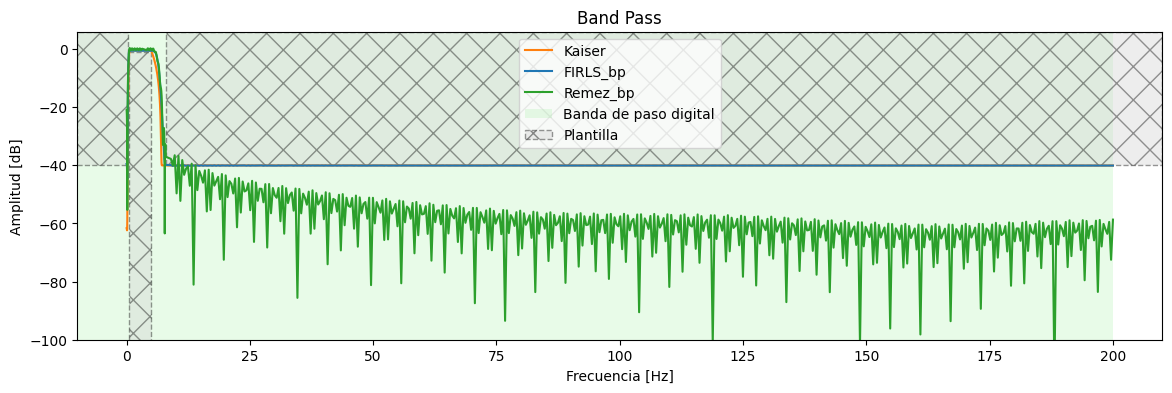

In [24]:
fig = plt.figure(figsize=(14, 4))
plt.plot(w_Hz, 20 * np.log10(np.abs(H_k_bp) + 1e-10), color='tab:orange', label='Kaiser')
plt.plot(w_Hz, 20 * np.log10(np.abs(H_firls_bp) + 1e-10), label='FIRLS_bp', color='tab:blue')
plt.plot(w_Hz, 20 * np.log10(np.abs(H_remez_bp) + 1e-10), label='Remez_bp', color='tab:green')
plot_plantilla(filter_type='bandpass',fpass=fpass,ripple=ripple,fstop=fstop,attenuation=attenuation,fs=fs)
plt.title('Band Pass')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.legend()

### Filtros IIR para PPG

También diseñé filtros IIR para PPG usando los métodos **Butterworth** y **Chebyshev Tipo 1**, con los mismos criterios que en ECG.

Parámetros del diseño:

- **Banda de paso**: 0.5 – 5.0 Hz  
- **Banda de stop**: 0.2 – 8.0 Hz  
- **Ripple**: 0.1 dB  
- **Atenuación**: 40 dB  
- **Frecuencia de muestreo**: 400 Hz

Ambos filtros se generaron con `iirdesign` y se pasaron a la forma `sos` (Second-Order Sections) para tener más estabilidad numérica. La respuesta en frecuencia se evaluó sobre la misma grilla `w_rad`.

- **Butterworth** → transición suave, sin ripple, respuesta más redondeada.
- **Chebyshev Tipo 1** → permite transiciones más rápidas a costa de tener ripple en la banda de paso.


In [25]:
fs = 400
fpass = np.array([0.5, 5.0])         # Banda de paso para PPG
fstop = np.array([0.2, 8.0])         # Banda de stop para PPG
ripple = 0.1                         # dB
attenuation = 40                    # dB

''' IIR: Butterworth '''
mi_sos_butter = sig.iirdesign(
    fpass,
    fstop,
    gpass=ripple,
    gstop=attenuation,
    ftype='butter',
    output='sos',
    fs=fs
)
w_butter, hh_butter = sig.sosfreqz(mi_sos_butter, worN=w_rad)

''' IIR: Chebyshev 1 '''
mi_sos_cheby = sig.iirdesign(
    fpass,
    fstop,
    gpass=ripple,
    gstop=attenuation,
    ftype='cheby1',
    output='sos',
    fs=fs
)
w_cheby, hh_cheby = sig.sosfreqz(mi_sos_cheby, worN=w_rad)


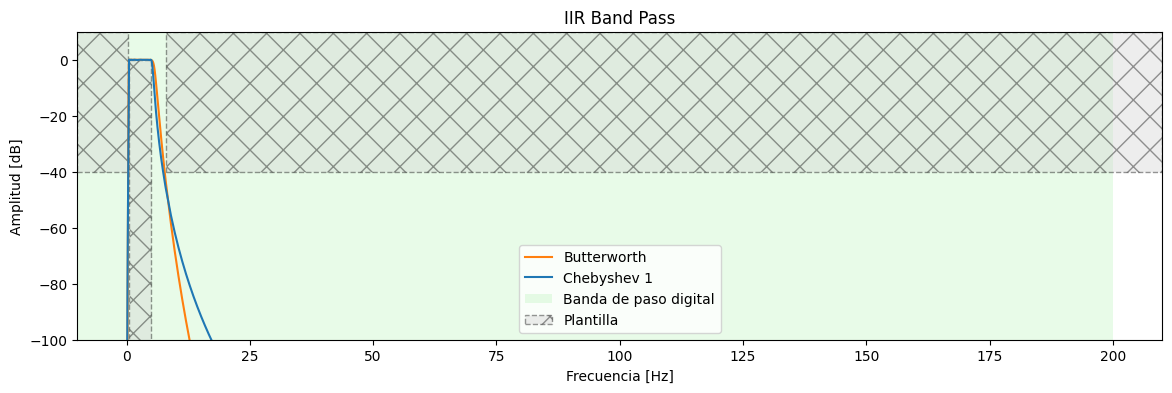

In [26]:
fig = plt.figure(figsize=(14, 4))
plt.plot(w_Hz, 20 * np.log10(np.abs(hh_butter) + 1e-10), color='tab:orange', label='Butterworth')
plt.plot(w_Hz, 20 * np.log10(np.abs(hh_cheby) + 1e-10), color='tab:blue', label='Chebyshev 1')
plot_plantilla(filter_type='bandpass', fpass=fpass, ripple=ripple, fstop=fstop, attenuation=attenuation, fs=fs)
plt.title('IIR Band Pass')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud [dB]')
plt.legend()
plt.show()

### Aplicación de los filtros sobre la señal PPG

#### IIR

Apliqué los filtros IIR usando `sosfiltfilt`, igual que en ECG. Esto hace un **filtrado bidireccional**, eliminando la distorsión de fase (ya que aplica el filtro hacia adelante y después hacia atrás)(ya lo explique).

- `ppg_iir_butter`: filtrado con Butterworth  
- `ppg_iir_cheby`: filtrado con Chebyshev Tipo 1  

#### FIR

Para los filtros FIR, simplemente usé `np.convolve` con `mode='same'`. Como son filtros no recursivos, no es necesario usar `filtfilt`.

- `ppg_fir_kaiser`: convolución con el pasa banda de Kaiser  
- `ppg_fir_firls`: convolución con el pasa banda de FIRLS  
- `ppg_fir_remez`: convolución con el pasa banda de Remez


In [29]:
''' Aplicación de filtros IIR '''
ppg_iir_butter = sig.sosfiltfilt(mi_sos_butter, ppg)
ppg_iir_cheby = sig.sosfiltfilt(mi_sos_cheby, ppg)

''' Aplicación de filtros FIR '''
ppg_fir_kaiser = np.convolve(ppg, h_k_bp, mode='same')
ppg_fir_firls = np.convolve(ppg, h_firls_bp, mode='same')
ppg_fir_remez = np.convolve(ppg, h_remez_bp, mode='same')

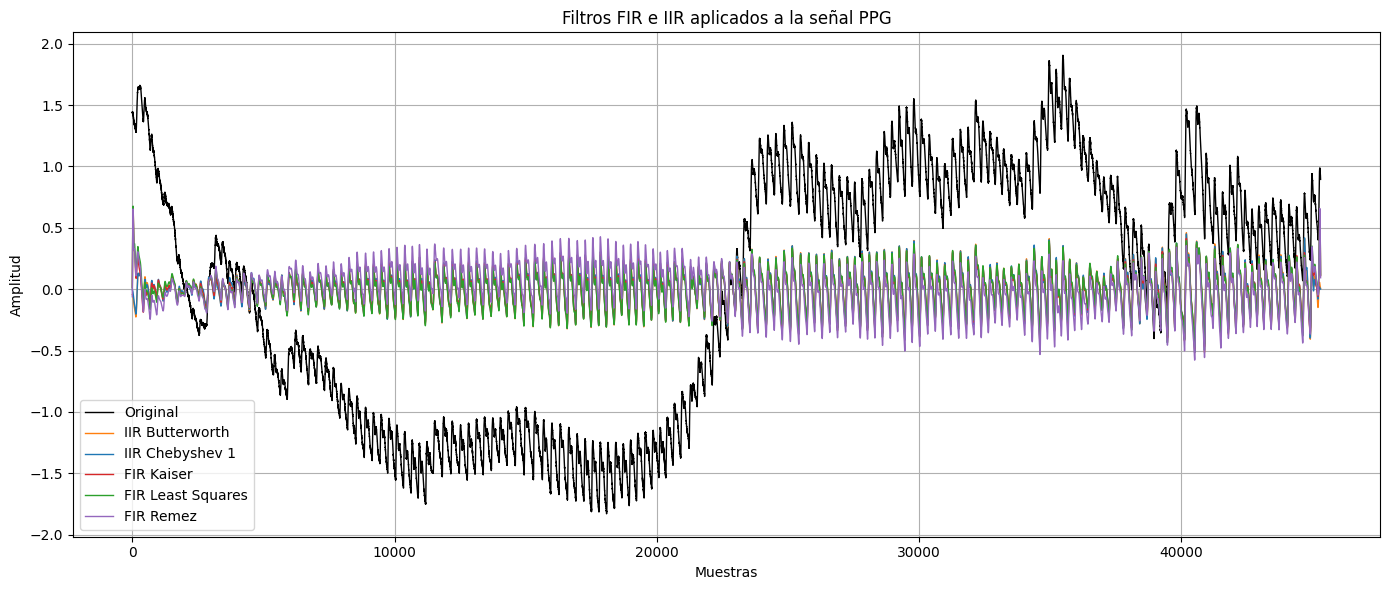

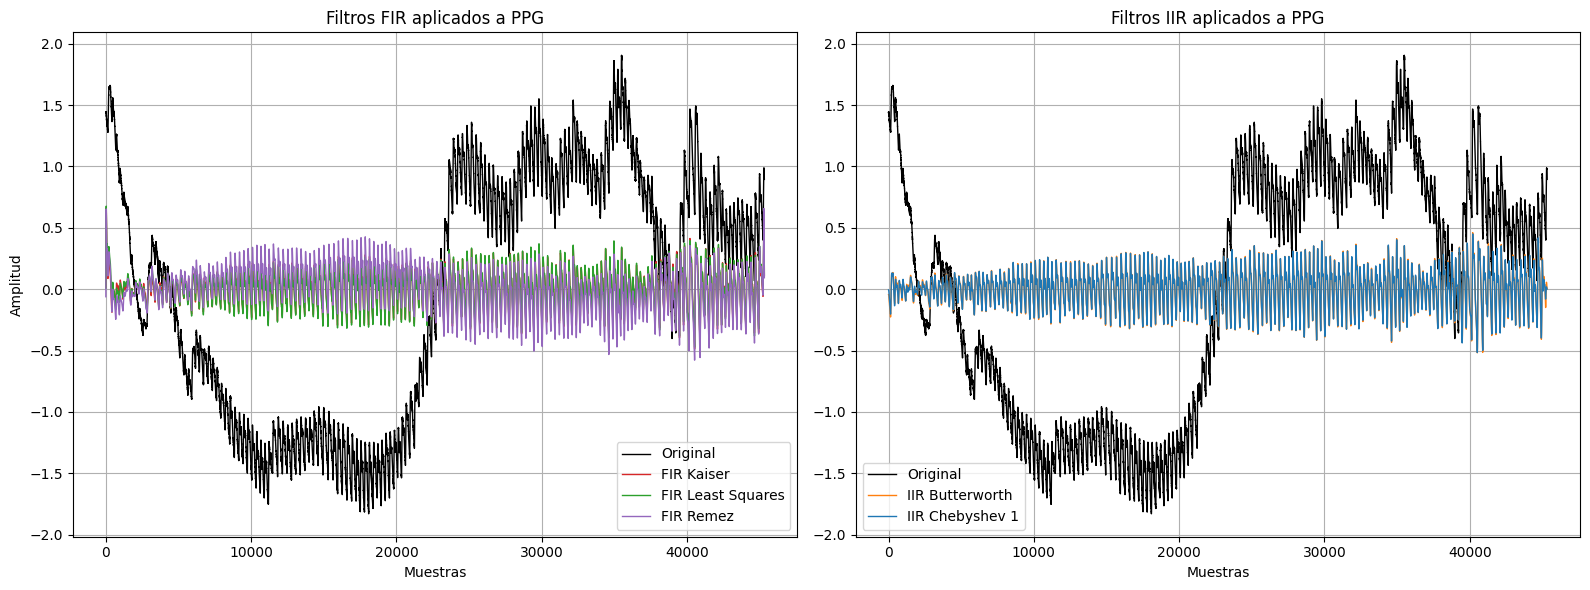

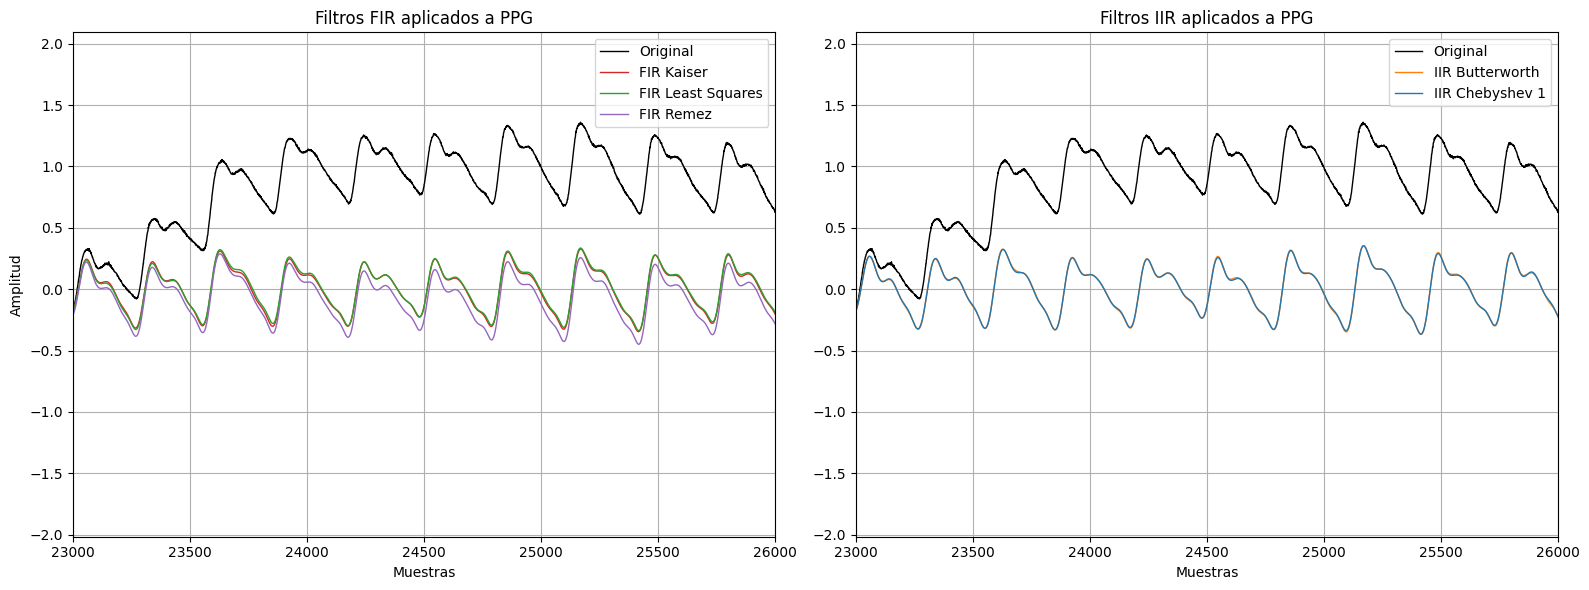

In [30]:
''' Ploteo de resultados '''
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(ppg, label='Original', color='black', linewidth=1)
ax.plot(ppg_iir_butter, label='IIR Butterworth', color='tab:orange', linewidth=1)
ax.plot(ppg_iir_cheby, label='IIR Chebyshev 1', color='tab:blue', linewidth=1)
ax.plot(ppg_fir_kaiser, label='FIR Kaiser', color='tab:red', linewidth=1)
ax.plot(ppg_fir_firls, label='FIR Least Squares', color='tab:green', linewidth=1)
ax.plot(ppg_fir_remez, label='FIR Remez', color='tab:purple', linewidth=1)

ax.set_title('Filtros FIR e IIR aplicados a la señal PPG')
ax.set_xlabel('Muestras')
ax.set_ylabel('Amplitud')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# FIR
axs[0].plot(ppg, label='Original', color='black', linewidth=1)
axs[0].plot(ppg_fir_kaiser, label='FIR Kaiser', color='tab:red', linewidth=1)
axs[0].plot(ppg_fir_firls, label='FIR Least Squares', color='tab:green', linewidth=1)
axs[0].plot(ppg_fir_remez, label='FIR Remez', color='tab:purple', linewidth=1)
axs[0].set_title('Filtros FIR aplicados a PPG')
axs[0].set_xlabel('Muestras')
axs[0].set_ylabel('Amplitud')
axs[0].legend()
axs[0].grid(True)

# IIR
axs[1].plot(ppg, label='Original', color='black', linewidth=1)
axs[1].plot(ppg_iir_butter, label='IIR Butterworth', color='tab:orange', linewidth=1)
axs[1].plot(ppg_iir_cheby, label='IIR Chebyshev 1', color='tab:blue', linewidth=1)
axs[1].set_title('Filtros IIR aplicados a PPG')
axs[1].set_xlabel('Muestras')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# FIR
axs[0].plot(ppg, label='Original', color='black', linewidth=1)
axs[0].plot(ppg_fir_kaiser, label='FIR Kaiser', color='tab:red', linewidth=1)
axs[0].plot(ppg_fir_firls, label='FIR Least Squares', color='tab:green', linewidth=1)
axs[0].plot(ppg_fir_remez, label='FIR Remez', color='tab:purple', linewidth=1)
axs[0].set_title('Filtros FIR aplicados a PPG')
axs[0].set_xlabel('Muestras')
axs[0].set_xlim(23000, 26000)  
axs[0].set_ylabel('Amplitud')
axs[0].legend()
axs[0].grid(True)

# IIR
axs[1].plot(ppg, label='Original', color='black', linewidth=1)
axs[1].plot(ppg_iir_butter, label='IIR Butterworth', color='tab:orange', linewidth=1)
axs[1].plot(ppg_iir_cheby, label='IIR Chebyshev 1', color='tab:blue', linewidth=1)
axs[1].set_title('Filtros IIR aplicados a PPG')
axs[1].set_xlabel('Muestras')
axs[1].set_xlim(23000, 26000) 
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


### Señales PPG filtradas – Vista extendida

En esta vista más larga se puede ver que **todos los filtros eliminan correctamente la deriva de línea base**.

Se nota una **diferencia entre Remez y Least Squares**: la señal filtrada con **Remez tiene más variación de amplitud** respecto a Least Squares.

Los **IIR** también funcionan bien y mantienen la forma general de la señal.



## Conclusiones finales

Los filtros **FIR** tienen la ventaja de que el **retardo de fase es constante**, lo que hace que no deformen la forma de onda. Pero en la práctica me resultaron bastante **difíciles de implementar**: tuve que ajustar muchas veces los valores, mover bandas, cambiar ganancias, y usar muchos coeficientes para que cumplan la plantilla.

Los **IIR**, en cambio, fueron mucho más **fáciles de diseñar**. Con `iirdesign` se obtiene una buena respuesta sin tanto ajuste fino, y usando `filtfilt` se evita el problema de la fase.

En resumen, ambos tipos de filtros funcionaron, pero **los FIR requieren más trabajo manual** para lograr lo que uno quiere.

